In [1]:
import pandas as pd
import torch

In [2]:
df = pd.read_csv('voice.csv')
df

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


In [3]:
x = df.values[:, :-1]
x = torch.tensor(x.astype('float32'))
y = df.values[:, -1]
print('y', y)
y[y == 'male'] = 0
y[y == 'female'] = 1
print('y', y)
y = torch.tensor(y.astype('float32'))

y ['male' 'male' 'male' ... 'female' 'female' 'female']
y [0 0 0 ... 1 1 1]


In [4]:
from torch.utils.data import random_split, DataLoader, Dataset

In [5]:
class TensorDataset(Dataset):
    def __init__(self, *tensors, mu, std):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors
        self.mu = mu
        self.std = std

    def __getitem__(self, index):
        x = self.tensors[0][index]
        x = (x - self.mu) / self.std
        y = self.tensors[1][index]
        return (x, y)

    def __len__(self):
        return self.tensors[0].size(0)

In [6]:
train_size = round(len(x) * 0.7)
test_size = len(x) - train_size
train_idx, test_idx = random_split(range(len(x)), [train_size, test_size])
mu = x[train_idx].mean(dim=0)
std = x[train_idx].std(dim=0)

In [7]:
dataset_train = TensorDataset(x[train_idx], y[train_idx], mu=mu, std=std)
dataset_test = TensorDataset(x[test_idx], y[test_idx], mu=mu, std=std)

In [8]:
print('train', len(dataset_train))
print('test', len(dataset_test))

train 2218
test 950


In [9]:
batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
from torch import nn

class VoiceEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20, 12),
            nn.ReLU(True),
            nn.BatchNorm1d(12),
            nn.Linear(12, 7),
            nn.ReLU(True),
            nn.BatchNorm1d(7),
            nn.Linear(7, 3),
        )
    
    def forward(self, x):
        return self.encoder(x)

class VoiceDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(3, 7),
            nn.ReLU(True),
            nn.BatchNorm1d(7),
            nn.Linear(7, 12),
            nn.ReLU(True),
            nn.BatchNorm1d(12),
            nn.Linear(12, 20),
        )
    
    def forward(self, x):
        return self.decoder(x)

class VoiceAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VoiceEncoder()
        self.decoder = VoiceDecoder()

    def forward(self, x):
        encode = self.encoder(x)
        return self.decoder(encode)

In [11]:
device = torch.device('cuda:2')
model = VoiceAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

In [12]:
# test model
test_x = torch.rand(16, 20).to(device)
model(test_x).shape

torch.Size([16, 20])

In [13]:
from tqdm import tqdm
def train(model, data, epoch, criterion, optimizer, device, is_tqdm=False):
    model.train()
    loss_list = []
    acc_count = 0

    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, _) in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon = model(batch).squeeze() # predict the label
        loss = criterion(recon, batch) # calculate error
        loss_list.append(loss.item())
        
        loss.backward()  # back-propagation
        optimizer.step() # gradient descent

    return sum(loss_list) / len(loss_list)

def test(model, data, criterion, device, is_tqdm=False):
    model.eval()
    loss_list = []

    acc_count = 0
    loader = enumerate(data)
    if is_tqdm:
        loader = tqdm(loader, total=len(data))
    for i, (batch, _) in loader:
        batch = batch.to(device)

        recon = model(batch).squeeze()
        loss = criterion(recon, batch)
        loss_list.append(loss.item())

    return sum(loss_list) / len(loss_list)

In [14]:
import matplotlib.pyplot as plt

class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.val_loss_list = []
    
    def update(self, train_loss, val_loss):
        self.train_loss_list.append(train_loss)
        self.val_loss_list.append(val_loss)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.figure(figsize=(12, 4))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()

In [15]:
from torch.optim.lr_scheduler import StepLR

max_epoch = 280
step_size = 70
log_interval = 20

scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)

meter = Meter()

for epoch in range(1, max_epoch + 1):
    if epoch % log_interval == 0:
        tqdm.write('==========Train Epoch {}=========='.format(epoch))
    train_loss = train(model, train_data, epoch, criterion, optimizer, device)
    test_loss = test(model, test_data, criterion, device)
    scheduler.step()
    
    meter.update(train_loss, test_loss)
    
    if epoch % log_interval == 0:
        print('Train loss: {:.04f} - Test loss: {:.04f}'.format(
            train_loss, test_loss,
        ))

==========Train Epoch 20==========
Train loss: 0.2372 - Test loss: 0.2029
==========Train Epoch 40==========
Train loss: 0.2124 - Test loss: 0.1882
==========Train Epoch 60==========
Train loss: 0.2086 - Test loss: 0.1908
==========Train Epoch 80==========
Train loss: 0.2040 - Test loss: 0.1726
==========Train Epoch 100==========
Train loss: 0.2029 - Test loss: 0.1746
==========Train Epoch 120==========
Train loss: 0.2031 - Test loss: 0.1704
==========Train Epoch 140==========
Train loss: 0.2037 - Test loss: 0.1746
==========Train Epoch 160==========
Train loss: 0.2018 - Test loss: 0.1684
==========Train Epoch 180==========
Train loss: 0.1994 - Test loss: 0.1672
==========Train Epoch 200==========
Train loss: 0.2005 - Test loss: 0.1694
==========Train Epoch 220==========
Train loss: 0.1951 - Test loss: 0.1633
==========Train Epoch 240==========
Train loss: 0.1933 - Test loss: 0.1640
==========Train Epoch 260==========
Train loss: 0.1902 - Test loss: 0.1671
==========Train Epoch 280====

In [16]:
x_ = dataset_train[0][0].to(device).unsqueeze(0)
recon = model(x_).detach()
print(recon)
print(x_)

tensor([[ 0.8072, -1.1753,  0.5408,  1.0598,  0.0389, -1.1802, -0.2188, -0.2921,
         -0.9972, -0.9935,  0.4453,  0.8072,  0.8947,  0.5301,  0.3915,  0.6705,
          0.1734,  0.7438,  0.7409, -0.4271]], device='cuda:2')
tensor([[ 0.5599, -1.7435,  0.3083,  0.9719, -0.6760, -1.4762,  0.0703, -0.1513,
         -1.9402, -1.3306,  0.3611,  0.5599,  0.9533,  0.5285,  0.6739,  0.5521,
         -0.4632,  0.6494,  0.6578, -0.6161]], device='cuda:2')


In [19]:
# torch.save(model.state_dict(), 'ckpts/ae_dim3.pt')

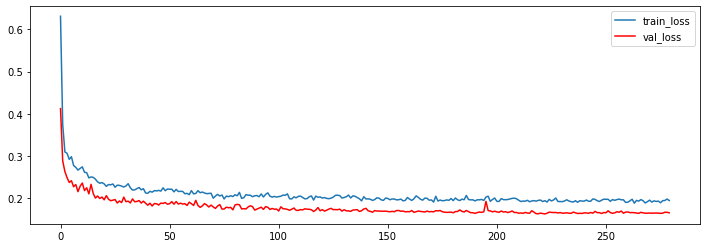

In [18]:
meter.plot()

- AE lr1e-2 step40 gamma 0.3 e160  
Train loss: 0.1878 - Test loss: 0.2087  
Train loss: 0.1906 - Test loss: 0.1953
- AE 20,10,5,5  
Train loss: 0.1646 - Test loss: 0.1718  
- AE 20,12,7,5  
Train loss: 0.1596 - Test loss: 0.1635  
Train loss: 0.1502 - Test loss: 0.1525  
Train loss: 0.1332 - Test loss: 0.1363  
- AE 20,12,7,5 lr 2e-3 e300 step100 gamma0.3  
Train loss: 0.0961 - Test loss: 0.0964  
- cont. lr 1e-2 e210 step70 gamma 0.5  
Train loss: 0.0881 - Test loss: 0.0925  
Train loss: 0.0845 - Test loss: 0.0933  